In [1]:
import os

def count_images_in_folder(folder_path):
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            count = len(os.listdir(class_folder))
            print(f"{class_name}: {count} images")

train_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\Final Project\\train" 
test_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\Final Project\\test" 

print("Train folder:")
count_images_in_folder(train_dir)

print("\nTest folder:")
count_images_in_folder(test_dir)

Train folder:
AD: 2561 images
CONTROL: 3010 images
PD: 906 images

Test folder:
AD: 639 images
CONTROL: 662 images
PD: 61 images


In [3]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\CIC\\6th Semester\\Pattern Recognition\\Final Project\\train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\\CIC\\6th Semester\\Pattern Recognition\\Final Project\\test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 6477 files belonging to 3 classes.
Found 1362 files belonging to 3 classes.
Class names: ['AD', 'CONTROL', 'PD']


In [4]:

class_names = train_ds.class_names
print("Classes:", class_names)

# Count images in the training set
num_train = sum(1 for _ in train_ds.unbatch())
num_test = sum(1 for _ in test_ds.unbatch())
print(f"Training images: {num_train}")
print(f"Testing images: {num_test}")


Classes: ['AD', 'CONTROL', 'PD']
Training images: 6477
Testing images: 1362


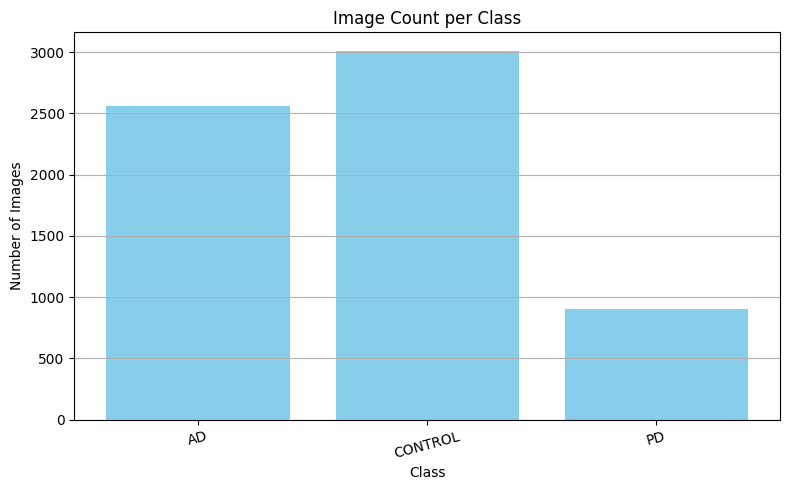

Average image size: 176.0 x 208.0


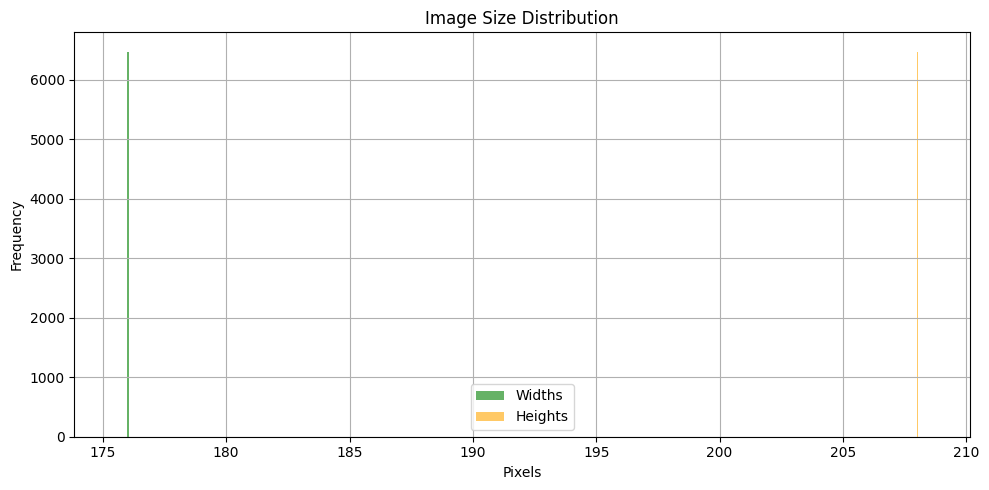

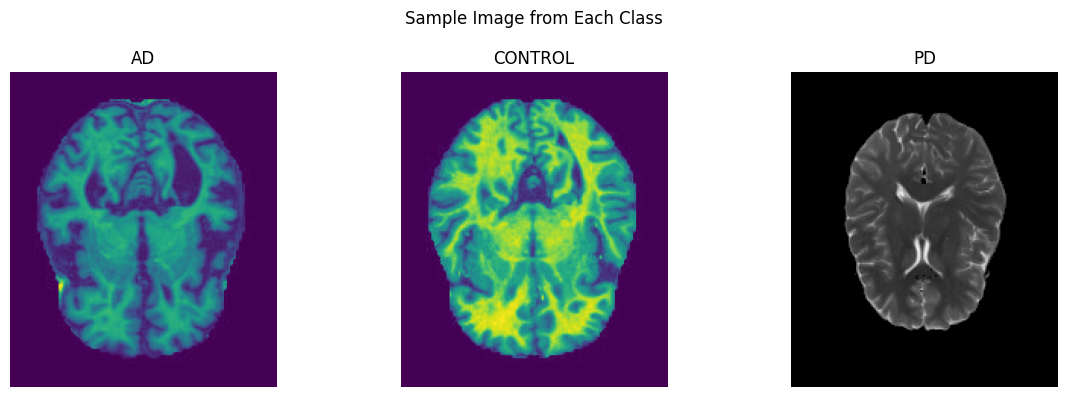

In [5]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# === Update these paths based on your actual folder ===
train_dir = "D:\\CIC\\6th Semester\\Pattern Recognition\\vs\\train"

# Containers
class_counts = {}
image_shapes = []
example_images = {}

# Loop through classes
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = 0
        for idx, file in enumerate(os.listdir(class_path)):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
                img_path = os.path.join(class_path, file)
                try:
                    img = Image.open(img_path)
                    image_shapes.append(img.size)  # (width, height)
                    if idx == 0:
                        example_images[class_name] = img
                except Exception as e:
                    print(f"Failed to load image: {img_path} due to {e}")
        class_counts[class_name] = count

# --- Plot: Image count per class ---
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Plot: Width and Height Distribution ---
widths, heights = zip(*image_shapes)
print(f"Average image size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")

plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.6, label='Widths', color='green')
plt.hist(heights, bins=20, alpha=0.6, label='Heights', color='orange')
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Show One Example per Class ---
plt.figure(figsize=(12, 4))
for i, (label, img) in enumerate(example_images.items()):
    plt.subplot(1, len(example_images), i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Image from Each Class")
plt.tight_layout()
plt.show()


In [10]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize
    image = tf.image.adjust_contrast(image, 1.5)  # Enhance contrast
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

train_ds = train_ds.map(preprocess)
test_ds = test_ds.map(preprocess)


In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = (224, 224)

def resnet_preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # [-1, 1] scaling + color normalization
    return image, label

train_ds = train_ds.map(resnet_preprocess)
test_ds = test_ds.map(resnet_preprocess)


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Load ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D()
])

def extract_features(dataset):
    features, labels = [], []
    for images, lbls in dataset:
        feats = model(images)
        features.append(feats.numpy())
        labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from train and test sets
X_train, y_train = extract_features(train_ds)
X_test, y_test = extract_features(test_ds)


In [14]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np

# Encode labels if not integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

print("After SMOTE:")
print("X shape:", X_train_smote.shape)
print("Label distribution:", np.unique(y_train_smote, return_counts=True))


After SMOTE:
X shape: (9030, 2048)
Label distribution: (array([0, 1, 2]), array([3010, 3010, 3010]))


In [16]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", acc_xgb)


XGBoost Accuracy: 0.6967694566813509


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)


Random Forest Accuracy: 0.657856093979442


In [19]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train_smote, y_train_smote)
y_pred_lgbm = lgbm.predict(X_test)

acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", acc_lgbm)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115013
[LightGBM] [Info] Number of data points in the train set: 9030, number of used features: 452
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Accuracy: 0.657856093979442


d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Re-prepare train and test sets (if not already)
AUTOTUNE = tf.data.AUTOTUNE

train_ds_cnn = train_ds.cache().shuffle(1000).batch(32).prefetch(buffer_size=AUTOTUNE)
test_ds_cnn = test_ds.batch(32).prefetch(buffer_size=AUTOTUNE)

# CNN model
cnn_model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn_model.fit(
    train_ds_cnn,
    validation_data=test_ds_cnn,
    epochs=20,
    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = cnn_model.evaluate(test_ds_cnn)
print("CNN Accuracy:", test_acc)


Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, 224, 224, 3), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (None, None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None

In [21]:
# If train_ds is already batched
train_ds_cnn = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds_cnn = test_ds.prefetch(tf.data.AUTOTUNE)


In [23]:
# --- DNN Training Block (With ResNet Features + SMOTE) ---
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Input: X_train_smote (ResNet50 features) | y_train_smote (labels)
#        X_test (ResNet50 features) | y_test (original labels)
dnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_smote)), activation='softmax')
])

dnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train DNN
early_stop_dnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_dnn = dnn_model.fit(X_train_smote, y_train_smote,
                            validation_data=(X_test, y_test),
                            epochs=30,
                            batch_size=32,
                            callbacks=[early_stop_dnn])

# Evaluate DNN
loss_dnn, acc_dnn = dnn_model.evaluate(X_test, y_test)
print("DNN Accuracy:", acc_dnn)


Epoch 1/30


d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3322 - loss: 1.1730 - val_accuracy: 0.0448 - val_loss: 1.0997
Epoch 2/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3304 - loss: 1.0986 - val_accuracy: 0.4860 - val_loss: 1.0988
Epoch 3/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3264 - loss: 1.0987 - val_accuracy: 0.0448 - val_loss: 1.1020
Epoch 4/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3290 - loss: 1.0986 - val_accuracy: 0.4860 - val_loss: 1.0977
Epoch 5/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3234 - loss: 1.0987 - val_accuracy: 0.0448 - val_loss: 1.1008
Epoch 6/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3324 - loss: 1.0987 - val_accuracy: 0.4860 - val_loss: 1.0978
Epoch 7/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3422 - loss: 1.0986 - val_accuracy: 0.0448 - val_loss: 1.1015
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1904 - loss: 1.0989 
DNN Accuracy: 0.48604992032051086


In [24]:
  # --- CNN Training Block (Fixed) ---
  import tensorflow as tf
  from tensorflow.keras import layers, models
  from tensorflow.keras.callbacks import EarlyStopping
  
  # Assume train_ds and test_ds are already batched properly
  train_ds_cnn = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
  test_ds_cnn = test_ds.prefetch(tf.data.AUTOTUNE)
  
  # Build a simple CNN model
  cnn_model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D(2, 2),
      layers.Conv2D(128, (3, 3), activation='relu'),
      layers.GlobalAveragePooling2D(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(len(class_names), activation='softmax')
  ])
  
  cnn_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
  
  # Train CNN
  early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
  history_cnn = cnn_model.fit(train_ds_cnn,
                              validation_data=test_ds_cnn,
                              epochs=20,
                              callbacks=[early_stop])
  
  # Evaluate CNN
  test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_ds_cnn)
  print("CNN Accuracy:", test_acc_cnn)

Epoch 1/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 153s 677ms/step - accuracy: 0.4319 - loss: 1.5364 - val_accuracy: 0.4860 - val_loss: 0.8904
Epoch 2/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 132s 649ms/step - accuracy: 0.4451 - loss: 1.0107 - val_accuracy: 0.4860 - val_loss: 0.8990
Epoch 3/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 138s 682ms/step - accuracy: 0.4519 - loss: 1.0115 - val_accuracy: 0.4860 - val_loss: 0.8904
Epoch 4/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 131s 645ms/step - accuracy: 0.4623 - loss: 1.0047 - val_accuracy: 0.4860 - val_loss: 0.9012
Epoch 5/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 142s 698ms/step - accuracy: 0.4445 - loss: 1.0003 - val_accuracy: 0.4860 - val_loss: 0.8966
Epoch 6/20
203/203 ━━━━━━━━━━━━━━━━━━━━ 137s 676ms/step - accuracy: 0.4598 - loss: 1.0114 - val_accuracy: 0.4860 - val_loss: 0.9095
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.1904 - loss: 0.8950
CNN Accuracy: 0.48604992032051086


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step

--- CNN Classification Report ---
              precision    recall  f1-score   support

          AD       0.00      0.00      0.00       639
     CONTROL       0.49      1.00      0.65       662
          PD       0.00      0.00      0.00        61

    accuracy                           0.49      1362
   macro avg       0.16      0.33      0.22      1362
weighted avg       0.24      0.49      0.32      1362



d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

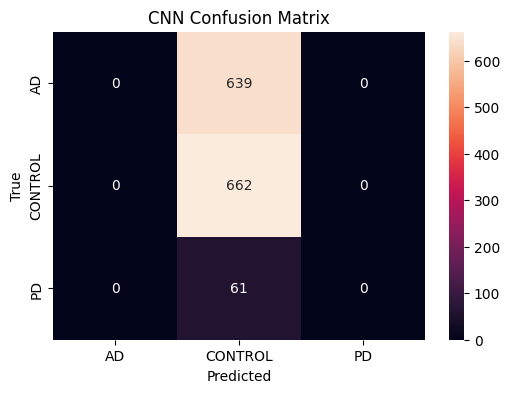

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- DNN Classification Report ---
              precision    recall  f1-score   support

          AD       0.00      0.00      0.00       639
     CONTROL       0.49      1.00      0.65       662
          PD       0.00      0.00      0.00        61

    accuracy                           0.49      1362
   macro avg       0.16      0.33      0.22      1362
weighted avg       0.24      0.49      0.32      1362



d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\CIC\6th Semester\Pattern Recognition\Final Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

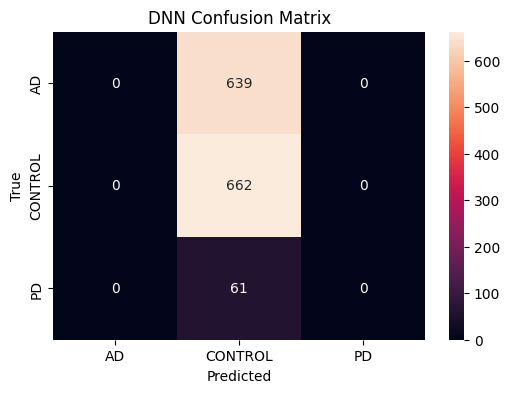

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# CNN evaluation
y_pred_cnn = np.argmax(cnn_model.predict(test_ds_cnn), axis=1)
y_true_cnn = np.concatenate([label.numpy() for _, label in test_ds_cnn])
print("\n--- CNN Classification Report ---")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

# Plotting the CNN confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_true_cnn, y_pred_cnn), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# DNN evaluation - Make sure y_test_enc is correctly defined (encoding labels if needed)
if 'y_test_enc' not in locals():  # Check if y_test_enc is defined
    # Assuming you have a categorical label for the test set, we need to encode y_test
    encoder = LabelEncoder()
    y_test_enc = encoder.fit_transform(y_test)  # Encode the labels if they are not one-hot encoded

# DNN prediction and evaluation
y_pred_dnn = np.argmax(dnn_model.predict(X_test), axis=1)
print("\n--- DNN Classification Report ---")
print(classification_report(y_test_enc, y_pred_dnn, target_names=class_names))

# Plotting the DNN confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_enc, y_pred_dnn), annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('DNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# --- Prediction Cell for New Image ---
from tensorflow.keras.preprocessing import image

def predict_new_image(img_path, model, model_type='cnn'):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    if model_type == 'cnn':
        img_array = img_array / 255.0
    elif model_type == 'dnn':
        from tensorflow.keras.applications.resnet50 import preprocess_input
        img_array = preprocess_input(img_array)
        features = model.layers[0](img_array)
        img_array = tf.keras.layers.GlobalAveragePooling2D()(features)
        img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    print("Predicted class:", class_names[predicted_class])
    return class_names[predicted_class]
